In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import cv2
import sklearn
import PIL
import torch
import torchvision
from matplotlib import cm

import warnings
warnings.filterwarnings('ignore')

### Зачем
- Посмотрим, как проводится операция свертки;
- Посмотрим, как работает pooling;
- Попробуем собрать сверточную нейронную сеть на PyTorch

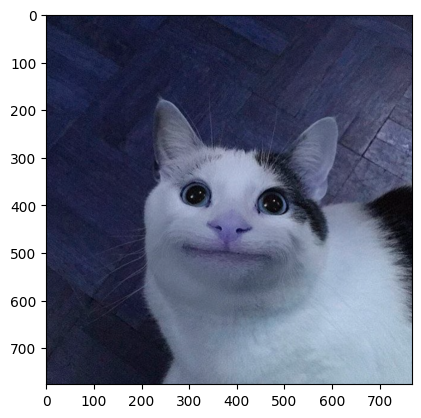

In [2]:
image = cv2.imread('./image.png')
plt.imshow(image);

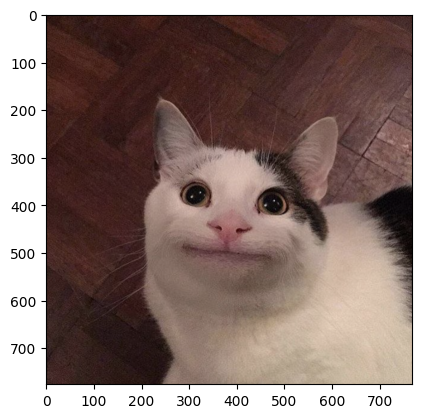

In [ ]:
image_ex = image[...,::-1] # так как в OpenCV, исторчески, изображение идёт не как RGB каналы, а как BGR
plt.imshow(image_ex)

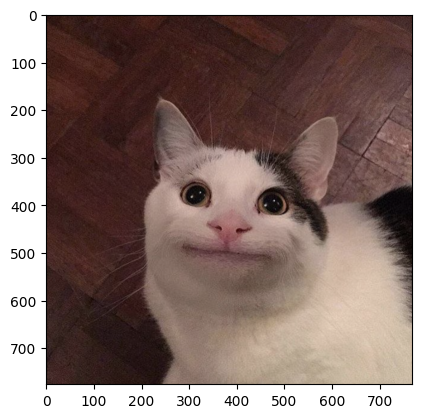

In [4]:
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb);

Посмотрим на каналы изображения отдельно

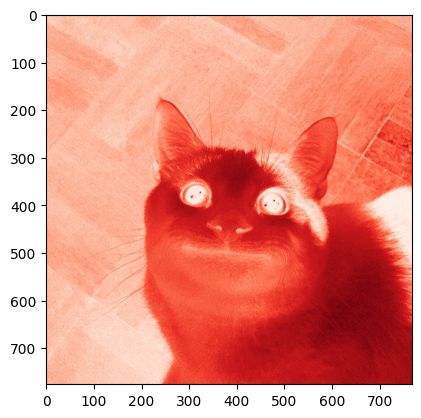

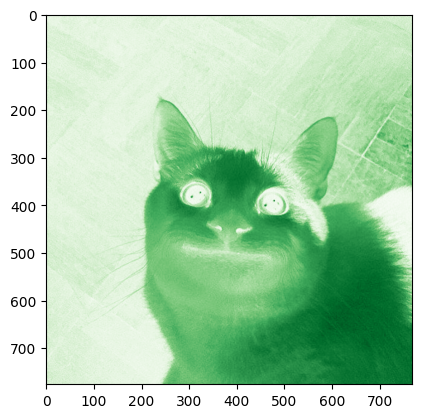

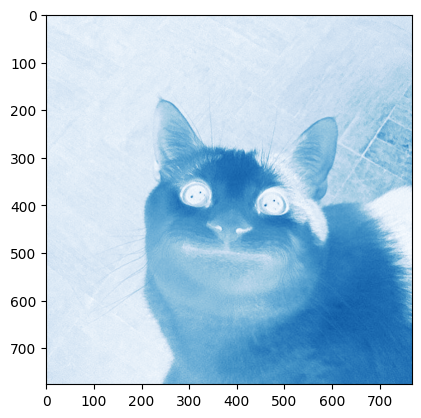

In [5]:
img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 0], cmap=cm.Reds)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 1], cmap=cm.Greens)
plt.show()

img_mat = np.array(image_rgb)
plt.imshow(img_mat[:, :, 2], cmap=cm.Blues)
plt.show()

# Операция свертки

- Количество входных каналов `in_channels`
- Количество выходных каналов `out_channels`
- Размер ядра `kernel_size`
- Шаг `stride`
- Паддинг `padding`
- Режим паддинга `padding_mode` (`'zeros'`, `'reflect'`, ...)


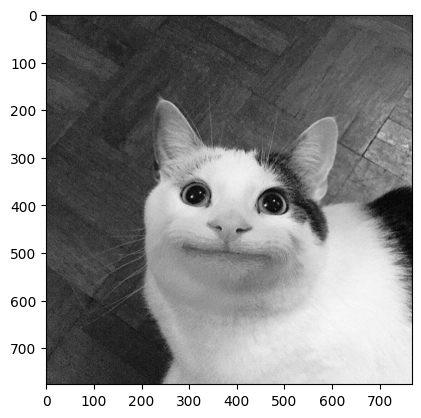

In [6]:
bw_image = cv2.imread('./image.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(bw_image, cmap=plt.cm.Greys_r)

In [7]:
# !pip3 install scipy

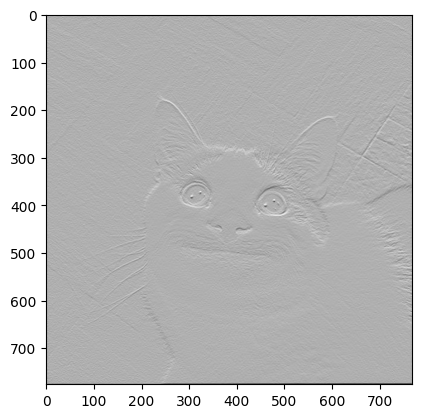

In [8]:
from scipy.signal import convolve2d

G_y = np.array([
    [1, 2, 1],
    [0, 0, 0],
    [-1, -2, -1]
])

res_y = convolve2d(bw_image, G_y, "same")
plt.imshow(res_y, cmap=plt.cm.Greys_r)

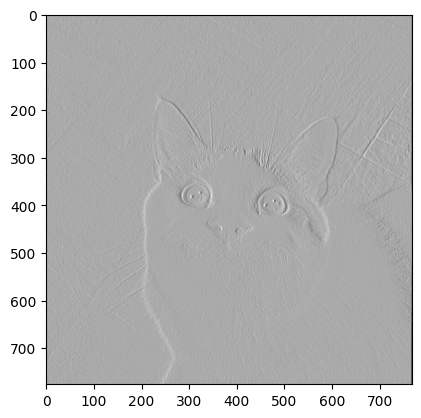

In [9]:
G_x = np.array([
    [-1, 0, 1],
    [-2, 0, 2],
    [-1, 0, 1]
])

res_x = convolve2d(bw_image, G_y.T, "same")
plt.imshow(res_x, cmap=plt.cm.Greys_r)

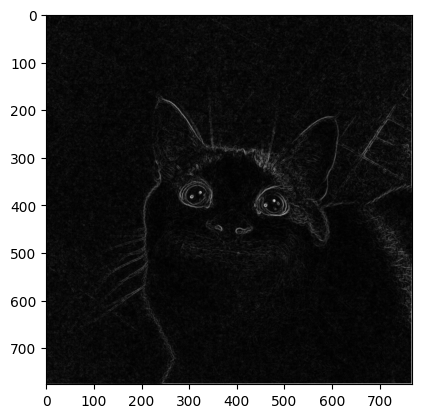

In [10]:
res_sobel = (res_x**2 + res_y**2)**0.5
plt.imshow(res_sobel, cmap=plt.cm.Greys_r)

# Пулинг

In [11]:
import numpy as np

conv_output = np.array([
    [10, 12,  8,  7],
    [ 4, 11,  5,  9],
    [18, 13,  7,  7],
    [ 3, 15,  2,  2]
])
conv_output

array([[10, 12,  8,  7],
       [ 4, 11,  5,  9],
       [18, 13,  7,  7],
       [ 3, 15,  2,  2]])

Сначала попробуем со `stride=2`

In [12]:
pool_size = 2
stride = 2

def get_pools(img=conv_output, pool_size=2, stride=2):

    pools = []
    for i in np.arange(conv_output.shape[0], step=stride):
        for j in np.arange(conv_output.shape[0], step=stride):
            mat = conv_output[i:i+pool_size, j:j+pool_size]
            pools.append(mat)
    pools = np.array(pools)
    return pools

pools = get_pools()
pools

array([[[10, 12],
        [ 4, 11]],

       [[ 8,  7],
        [ 5,  9]],

       [[18, 13],
        [ 3, 15]],

       [[ 7,  7],
        [ 2,  2]]])

In [13]:
def max_pooling(pools: np.array) -> np.array:

    num_pools = pools.shape[0]

    # Размер матрицы после пулинга
    tgt_shape = (int(np.sqrt(num_pools)), int(np.sqrt(num_pools)))

    # Здесь будем хранить максимумы с каждого из пулов
    pooled = []
    for pool in pools:
        pooled.append(np.max(pool))

    return np.array(pooled).reshape(tgt_shape)

In [14]:
max_pooling(pools=pools)

array([[12,  9],
       [18,  7]])

# Сверточная нейронная сеть

In [5]:
import torch
import torch.nn.functional as F
import torchvision
import os
from torch import nn
from tqdm import tqdm

In [16]:
transform = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

In [17]:
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [18]:
seed_everything(42)

mnist_train = torchvision.datasets.MNIST(
    './mnist/',
    train=True,
    download=True,
    transform=transform
)

mnist_val = torchvision.datasets.MNIST(
    './mnist/',
    train=False,
    download=True,
    transform=transform
)

train_dataloader = torch.utils.data.DataLoader(mnist_train, batch_size=64, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(mnist_val, batch_size=64, shuffle=True)

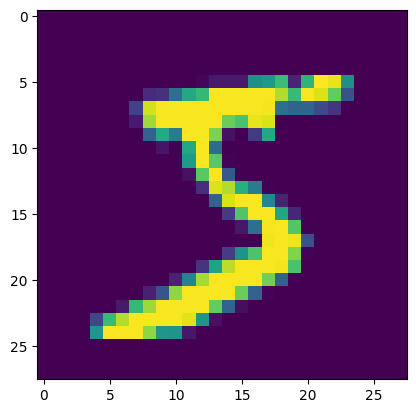

In [19]:
plt.imshow(mnist_train[0][0].squeeze(0).numpy().reshape([28, 28]))

In [20]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [21]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(n_epochs):

        # обучение
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # валидация
        if epoch % 2 == 0:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())

            print(f'Epoch: {epoch}, loss: {np.mean(val_loss)}, accuracy: {np.mean(val_accuracy)}')

In [22]:
train(model, optimizer)

100%|██████████| 157/157 [00:02<00:00, 63.14it/s]


Epoch: 0, loss: 0.3203020393848419, accuracy: 0.9099


100%|██████████| 157/157 [00:02<00:00, 62.16it/s]


Epoch: 2, loss: 0.23288217186927795, accuracy: 0.9316


100%|██████████| 157/157 [00:02<00:00, 63.49it/s]

Epoch: 4, loss: 0.18695394694805145, accuracy: 0.9462


In [23]:
0.9462

0.9462

In [24]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5),  # grayscale
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=4),   # сократим изображение в 4 раза по каждой из сторон
    nn.Flatten(),
    nn.Linear(6*6*10, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)

optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [25]:
train(model, optimizer)

100%|██████████| 157/157 [00:03<00:00, 51.04it/s]


Epoch: 0, loss: 0.265990287065506, accuracy: 0.925


100%|██████████| 157/157 [00:04<00:00, 39.17it/s]


Epoch: 2, loss: 0.1271064132452011, accuracy: 0.9625


100%|██████████| 157/157 [00:03<00:00, 51.35it/s]

Epoch: 4, loss: 0.08593292534351349, accuracy: 0.9747


In [27]:
0.9747

0.9747

# Домашнее задание

Обучите сверточную нейронную сеть на датасете MNIST, взяв любой другой оптимизатор (кроме SGD) и любую другую функцию ошибки (кроме cross-entropy loss). Попробуйте поварьировать параметры: кол-во ядер, `kernel_size` и побить текущий бейзлайн в `0.9747`. Выведите количество обучаемых параметров.    
Какого качества удалось достичь? Попробуйте залоггировать Ваши результаты - построить графики того, как менялись метрики качества (accuracy, loss) с течением эпох, включить логгирование, сравнить результаты между собой при разных параметрах.

Любые дополнительные улучшения (как по методам, так и по коду пайплайна) приветствуются!

*Цель:* выработать навык обучения нейронных сетей (в частности сверточных) на основе средств PyTorch, начиная от загрузки датасетами и заканчивая выводами результатов, их логгированием, сравнением и анализом.

In [8]:
import random
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms
from torch.utils.data import DataLoader

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Device:", device)


Device: mps


In [7]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

In [9]:
train_tf = transforms.Compose([
    transforms.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

test_tf = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

mnist_train = torchvision.datasets.MNIST(root="./mnist", train=True,  download=True, transform=train_tf)
mnist_test  = torchvision.datasets.MNIST(root="./mnist", train=False, download=True, transform=test_tf)

train_loader = DataLoader(mnist_train, batch_size=128, shuffle=True,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(mnist_test,  batch_size=256, shuffle=False, num_workers=2, pin_memory=True)

len(mnist_train), len(mnist_test)

100%|██████████| 9.91M/9.91M [00:04<00:00, 2.40MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 225kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 954kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 12.1MB/s]


(60000, 10000)

In [10]:
n_classes = len(mnist_train.classes)
n_classes

10

In [11]:
def make_simple_cnn(C1=32, C2=64, k1=3, k2=3, p_drop=0.2):
    return nn.Sequential(
        nn.Conv2d(1, C1, kernel_size=k1, padding=k1//2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),

        nn.Conv2d(C1, C2, kernel_size=k2, padding=k2//2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),

        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Dropout(p_drop),
        nn.Linear(C2, 10)
    )

In [20]:
model = make_simple_cnn().to(device)

# посчитаем число обучаемых параметров
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Обучаемых параметров {total_params:,}")

Обучаемых параметров 19,466


In [ ]:
def multi_margin_loss_custom(logits, target, margin=1.0):
    # logits: (B, C), target: (B,)
    B, C = logits.shape
    # логит правильного класса
    z_y = logits.gather(1, target.view(-1,1))  # (B,1)
    # разности: margin - (z_y - z_j) = margin + z_j - z_y
    margins = margin + logits - z_y
    # не штрафуем правильный класс
    margins[torch.arange(B), target] = 0.0
    # hinge: max(0, .)
    loss_per_sample = margins.clamp_min(0).sum(dim=1)
    return loss_per_sample.mean()


In [ ]:
# criterion = nn.MultiMarginLoss(margin=1.0, p=1) не сработало на MPS :(
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

In [27]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, total_correct, total_count = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)
        loss = multi_margin_loss_custom(logits, y, margin=1.0)

        if is_train:
            loss.backward()
            optimizer.step()

        total_loss   += loss.item() * x.size(0)
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_count  += x.size(0)

    avg_loss = total_loss / total_count
    avg_acc  = total_correct / total_count
    return avg_loss, avg_acc


In [ ]:
def train_model(model, optimizer, train_loader, val_loader, epochs=10, exp_name="exp1"):
    writer = SummaryWriter(log_dir=f"runs/mnist_cnn_{exp_name}")
    best_val_acc = 0.0

    for epoch in range(1, epochs+1):
        train_loss, train_acc = run_epoch(model, train_loader, optimizer)
        val_loss,   val_acc   = run_epoch(model, val_loader, optimizer=None)

        writer.add_scalar("train/loss", train_loss, epoch)
        writer.add_scalar("train/acc",  train_acc,  epoch)
        writer.add_scalar("val/loss",   val_loss,   epoch)
        writer.add_scalar("val/acc",    val_acc,    epoch)

        print(f"[{exp_name}] Epoch {epoch:02d}: "
              f"train_loss={train_loss:.4f} acc={train_acc:.4f} | "
              f"val_loss={val_loss:.4f} acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), f"best_mnist_cnn_{exp_name}.pt")

    print(f"[{exp_name}] Best val acc: {best_val_acc:.4f}")
    writer.close()
    return best_val_acc


In [31]:
model1 = make_simple_cnn().to(device)
optimizer1 = torch.optim.AdamW(model1.parameters(), lr=1e-3, weight_decay=1e-4)

acc1 = train_model(model1, optimizer1, train_loader, val_loader, epochs=10, exp_name="small")


[small] Epoch 01: train_loss=4.6387 acc=0.3705 | val_loss=1.9495 acc=0.7106
[small] Epoch 02: train_loss=2.0296 acc=0.6498 | val_loss=0.9517 acc=0.8564
[small] Epoch 03: train_loss=1.2805 acc=0.7654 | val_loss=0.5788 acc=0.9028
[small] Epoch 04: train_loss=0.9428 acc=0.8187 | val_loss=0.4080 acc=0.9255
[small] Epoch 05: train_loss=0.7579 acc=0.8486 | val_loss=0.3502 acc=0.9338
[small] Epoch 06: train_loss=0.6396 acc=0.8710 | val_loss=0.2725 acc=0.9450
[small] Epoch 07: train_loss=0.5717 acc=0.8822 | val_loss=0.2671 acc=0.9476
[small] Epoch 08: train_loss=0.5205 acc=0.8909 | val_loss=0.2326 acc=0.9491
[small] Epoch 09: train_loss=0.4764 acc=0.8981 | val_loss=0.2087 acc=0.9535
[small] Epoch 10: train_loss=0.4495 acc=0.9039 | val_loss=0.2056 acc=0.9535
[small] Best val acc: 0.9535


In [33]:
total_params1 = sum(p.numel() for p in model1.parameters() if p.requires_grad)
print(f"Обучаемых параметров {total_params1:,}")

Обучаемых параметров 19,466


In [32]:
model2 = make_simple_cnn(C1=48, C2=128, k1=5, k2=5, p_drop=0.3).to(device)
optimizer2 = torch.optim.AdamW(model2.parameters(), lr=1e-3, weight_decay=1e-4)

acc2 = train_model(model2, optimizer2, train_loader, val_loader, epochs=15, exp_name="big")


[big] Epoch 01: train_loss=2.2623 acc=0.6680 | val_loss=0.3427 acc=0.9397
[big] Epoch 02: train_loss=0.5104 acc=0.8990 | val_loss=0.1788 acc=0.9616
[big] Epoch 03: train_loss=0.3380 acc=0.9292 | val_loss=0.1183 acc=0.9734
[big] Epoch 04: train_loss=0.2544 acc=0.9446 | val_loss=0.0958 acc=0.9784
[big] Epoch 05: train_loss=0.2112 acc=0.9534 | val_loss=0.0874 acc=0.9787
[big] Epoch 06: train_loss=0.1840 acc=0.9576 | val_loss=0.0793 acc=0.9802
[big] Epoch 07: train_loss=0.1578 acc=0.9621 | val_loss=0.0668 acc=0.9824
[big] Epoch 08: train_loss=0.1427 acc=0.9659 | val_loss=0.0595 acc=0.9851
[big] Epoch 09: train_loss=0.1301 acc=0.9684 | val_loss=0.0466 acc=0.9868
[big] Epoch 10: train_loss=0.1205 acc=0.9699 | val_loss=0.0469 acc=0.9879
[big] Epoch 11: train_loss=0.1145 acc=0.9716 | val_loss=0.0515 acc=0.9858
[big] Epoch 12: train_loss=0.1057 acc=0.9733 | val_loss=0.0376 acc=0.9902
[big] Epoch 13: train_loss=0.1008 acc=0.9742 | val_loss=0.0368 acc=0.9904
[big] Epoch 14: train_loss=0.0991 acc=

In [34]:
total_params2 = sum(p.numel() for p in model2.parameters() if p.requires_grad)
print(f"Обучаемых параметров {total_params2:,}")

Обучаемых параметров 156,266


In [35]:
model_k3 = make_simple_cnn(C1=48, C2=128, k1=3, k2=3, p_drop=0.3).to(device)
optimizer_k3 = torch.optim.AdamW(model_k3.parameters(), lr=1e-3, weight_decay=1e-4)

acc_k3 = train_model(model_k3, optimizer_k3,
                     train_loader, val_loader,
                     epochs=15, exp_name="big_k3")


[big_k3] Epoch 01: train_loss=3.7761 acc=0.4582 | val_loss=1.2736 acc=0.7934
[big_k3] Epoch 02: train_loss=1.4421 acc=0.7387 | val_loss=0.6035 acc=0.8981
[big_k3] Epoch 03: train_loss=0.9095 acc=0.8248 | val_loss=0.3669 acc=0.9314
[big_k3] Epoch 04: train_loss=0.6864 acc=0.8616 | val_loss=0.2738 acc=0.9458
[big_k3] Epoch 05: train_loss=0.5567 acc=0.8829 | val_loss=0.2273 acc=0.9543
[big_k3] Epoch 06: train_loss=0.4782 acc=0.8989 | val_loss=0.2083 acc=0.9559
[big_k3] Epoch 07: train_loss=0.4232 acc=0.9077 | val_loss=0.2000 acc=0.9556
[big_k3] Epoch 08: train_loss=0.3868 acc=0.9164 | val_loss=0.1615 acc=0.9633
[big_k3] Epoch 09: train_loss=0.3513 acc=0.9227 | val_loss=0.1753 acc=0.9582
[big_k3] Epoch 10: train_loss=0.3263 acc=0.9270 | val_loss=0.1495 acc=0.9643
[big_k3] Epoch 11: train_loss=0.3022 acc=0.9335 | val_loss=0.1289 acc=0.9696
[big_k3] Epoch 12: train_loss=0.2893 acc=0.9346 | val_loss=0.1248 acc=0.9702
[big_k3] Epoch 13: train_loss=0.2713 acc=0.9390 | val_loss=0.1263 acc=0.9696

In [36]:
sum(p.numel() for p in model_k3.parameters() if p.requires_grad)


57194

In [37]:
def make_simple_cnn_bn(C1=32, C2=64, k1=3, k2=3, p_drop=0.2):
    return nn.Sequential(
        nn.Conv2d(1, C1, kernel_size=k1, padding=k1//2, bias=False),
        nn.BatchNorm2d(C1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),

        nn.Conv2d(C1, C2, kernel_size=k2, padding=k2//2, bias=False),
        nn.BatchNorm2d(C2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),

        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Dropout(p_drop),
        nn.Linear(C2, 10)
    )


In [38]:
model_bn_k3 = make_simple_cnn_bn(C1=48, C2=128, k1=3, k2=3, p_drop=0.3).to(device)
optimizer_bn_k3 = torch.optim.AdamW(model_bn_k3.parameters(), lr=1e-3, weight_decay=1e-4)

acc_bn_k3 = train_model(model_bn_k3, optimizer_bn_k3,
                        train_loader, val_loader,
                        epochs=15, exp_name="big_k3_bn")
print("params_bn_k3:", sum(p.numel() for p in model_bn_k3.parameters() if p.requires_grad))


[big_k3_bn] Epoch 01: train_loss=2.8346 acc=0.5684 | val_loss=1.0795 acc=0.8390
[big_k3_bn] Epoch 02: train_loss=1.4082 acc=0.7440 | val_loss=0.6244 acc=0.8914
[big_k3_bn] Epoch 03: train_loss=1.0514 acc=0.8003 | val_loss=0.4201 acc=0.9230
[big_k3_bn] Epoch 04: train_loss=0.8561 acc=0.8320 | val_loss=0.3722 acc=0.9316
[big_k3_bn] Epoch 05: train_loss=0.7307 acc=0.8544 | val_loss=0.2760 acc=0.9480
[big_k3_bn] Epoch 06: train_loss=0.6481 acc=0.8691 | val_loss=0.2455 acc=0.9528
[big_k3_bn] Epoch 07: train_loss=0.5725 acc=0.8832 | val_loss=0.2600 acc=0.9490
[big_k3_bn] Epoch 08: train_loss=0.5318 acc=0.8911 | val_loss=0.2083 acc=0.9615
[big_k3_bn] Epoch 09: train_loss=0.4856 acc=0.8990 | val_loss=0.2109 acc=0.9573
[big_k3_bn] Epoch 10: train_loss=0.4529 acc=0.9074 | val_loss=0.1933 acc=0.9607
[big_k3_bn] Epoch 11: train_loss=0.4204 acc=0.9135 | val_loss=0.1816 acc=0.9640
[big_k3_bn] Epoch 12: train_loss=0.3910 acc=0.9194 | val_loss=0.1653 acc=0.9634
[big_k3_bn] Epoch 13: train_loss=0.3666 

In [ ]:
def make_simple_cnn_bn_head(C1=48, C2=128, k1=3, k2=3, p_drop=0.3):
    return nn.Sequential(
        nn.Conv2d(1, C1, kernel_size=k1, padding=k1//2, bias=False),
        nn.BatchNorm2d(C1),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),

        nn.Conv2d(C1, C2, kernel_size=k2, padding=k2//2, bias=False),
        nn.BatchNorm2d(C2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(2),

        nn.AdaptiveAvgPool2d(1), # (B,C2,7,7)->(B,C2,1,1)
        nn.Flatten(), # (B,C2)

        nn.Dropout(p_drop),
        nn.Linear(C2, 128),
        nn.ReLU(inplace=True),
        nn.Dropout(p_drop),
        nn.Linear(128, 10)
    )


In [40]:
model_k3_bn_head = make_simple_cnn_bn_head().to(device)
print("params:", sum(p.numel() for p in model_k3_bn_head.parameters() if p.requires_grad))
opt = torch.optim.AdamW(model_k3_bn_head.parameters(), lr=1e-3, weight_decay=1e-4)
acc = train_model(model_k3_bn_head, opt, train_loader, val_loader, epochs=15, exp_name="big_k3_bn_head")

params: 73882
[big_k3_bn_head] Epoch 01: train_loss=3.1136 acc=0.4970 | val_loss=0.9444 acc=0.8112
[big_k3_bn_head] Epoch 02: train_loss=1.5097 acc=0.6934 | val_loss=0.6277 acc=0.8652
[big_k3_bn_head] Epoch 03: train_loss=1.0799 acc=0.7704 | val_loss=0.4253 acc=0.9004
[big_k3_bn_head] Epoch 04: train_loss=0.8593 acc=0.8127 | val_loss=0.2835 acc=0.9381
[big_k3_bn_head] Epoch 05: train_loss=0.7015 acc=0.8450 | val_loss=0.3104 acc=0.9274
[big_k3_bn_head] Epoch 06: train_loss=0.6153 acc=0.8626 | val_loss=0.2003 acc=0.9543
[big_k3_bn_head] Epoch 07: train_loss=0.5242 acc=0.8814 | val_loss=0.1651 acc=0.9600
[big_k3_bn_head] Epoch 08: train_loss=0.4560 acc=0.8975 | val_loss=0.1519 acc=0.9632
[big_k3_bn_head] Epoch 09: train_loss=0.4115 acc=0.9075 | val_loss=0.1457 acc=0.9638
[big_k3_bn_head] Epoch 10: train_loss=0.3789 acc=0.9144 | val_loss=0.1354 acc=0.9666
[big_k3_bn_head] Epoch 11: train_loss=0.3428 acc=0.9201 | val_loss=0.1177 acc=0.9703
[big_k3_bn_head] Epoch 12: train_loss=0.3185 acc=0.

In [41]:
def mse_loss_with_one_hot(logits, y, eps=0.1):
    probs = logits.softmax(dim=1)
    t = F.one_hot(y, num_classes=10).float()
    t = t * (1 - eps) + eps / 10
    return F.mse_loss(probs, t)


In [ ]:
def run_epoch(model, loader, optimizer=None):
    is_train = optimizer is not None
    model.train() if is_train else model.eval()

    total_loss, total_correct, total_count = 0.0, 0, 0

    for x, y in loader:
        x, y = x.to(device), y.to(device)

        if is_train:
            optimizer.zero_grad()

        logits = model(x)
        loss = mse_loss_with_one_hot(logits, y, eps=0.1)

        if is_train:
            loss.backward()
            optimizer.step()

        bs = x.size(0)
        total_loss    += loss.item() * bs
        total_correct += (logits.argmax(dim=1) == y).sum().item()
        total_count   += bs

    avg_loss = total_loss / total_count
    avg_acc  = total_correct / total_count
    return avg_loss, avg_acc


In [46]:
model_k3_bn_head = make_simple_cnn_bn_head().to(device)
opt = torch.optim.AdamW(model_k3_bn_head.parameters(), lr=1e-3, weight_decay=1e-4)
acc = train_model(model_k3_bn_head, opt, train_loader, val_loader, epochs=15, exp_name="k3_bn_head_mse")

[k3_bn_head_mse] Epoch 01: train_loss=0.0486 acc=0.5216 | val_loss=0.0291 acc=0.7613
[k3_bn_head_mse] Epoch 02: train_loss=0.0308 acc=0.7305 | val_loss=0.0138 acc=0.8990
[k3_bn_head_mse] Epoch 03: train_loss=0.0235 acc=0.8021 | val_loss=0.0103 acc=0.9220
[k3_bn_head_mse] Epoch 04: train_loss=0.0191 acc=0.8444 | val_loss=0.0081 acc=0.9406
[k3_bn_head_mse] Epoch 05: train_loss=0.0164 acc=0.8670 | val_loss=0.0065 acc=0.9510
[k3_bn_head_mse] Epoch 06: train_loss=0.0142 acc=0.8874 | val_loss=0.0056 acc=0.9569
[k3_bn_head_mse] Epoch 07: train_loss=0.0127 acc=0.9012 | val_loss=0.0051 acc=0.9631
[k3_bn_head_mse] Epoch 08: train_loss=0.0115 acc=0.9093 | val_loss=0.0046 acc=0.9673
[k3_bn_head_mse] Epoch 09: train_loss=0.0103 acc=0.9212 | val_loss=0.0046 acc=0.9659
[k3_bn_head_mse] Epoch 10: train_loss=0.0096 acc=0.9263 | val_loss=0.0043 acc=0.9690
[k3_bn_head_mse] Epoch 11: train_loss=0.0089 acc=0.9331 | val_loss=0.0038 acc=0.9720
[k3_bn_head_mse] Epoch 12: train_loss=0.0084 acc=0.9365 | val_los

Увеличение ядра до 5×5 и числа каналов (48/128) значительно улучшает распознавание (вероятно, из-за большего receptive field и богатства признаков) — 0.9907.

При 3×3 ядрах качество падает, но сложность сильно меньше, добавление «умной головы» частично компенсирует потерю.

MSE + label smoothing на MNIST стабильно и дружит с MPS, даёт прирост для компактных голов.

BN не дал выигрыша в простой настройке, вероятно, потенциал BN лучше раскрывается либо с большим батчем/другим lr, либо на более глубоких/богатых моделях